# City Scapes Image Segmentation

## About Dataset

### Context

Cityscapes data (dataset home page) contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the Pix2Pix paper. The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. This is one of the best datasets around for semantic segmentation tasks. The dataset consists of 297

### Content

This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

Example image from the dataset is shown below:

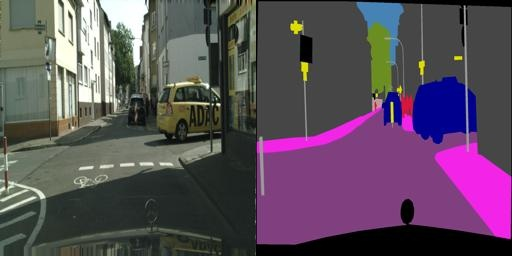

# Importing Libraries and Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
from tqdm import tqdm
import warnings
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore")

plt.style.use("seaborn-darkgrid")

sns.set_context("paper", font_scale=1.4)

BATCH_SIZE = 32

id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

category_map = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 2,
    8: 2,
    9: 2,
    10: 2,
    11: 2,
    12: 2,
    13: 3,
    14: 3,
    15: 3,
    16: 3,
    17: 4,
    18: 4,
    19: 5,
    20: 6,
    21: 6,
    22: 7,
    23: 7,
    24: 7,
    25: 7,
    26: 7,
    27: 7,
    28: 7,
    29: 7,
    30: 7
}

In [3]:
num_classes = len(id_map.keys())
print(num_classes)

31


In [4]:
def preprocess(path):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256)).resize((128, 128))
    img2 = img.crop((256, 0, 512, 256)).resize((128, 128))
    img1 = np.array(img1) / 255.
    img2 = np.array(img2)
    mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)
    for row in range(img2.shape[0]):
        for col in range(img2.shape[1]):
            a = img2[row, col, :]
            final_key = None
            final_d = None
            for key, value in id_map.items():
                d = np.sum(np.sqrt(pow(a - value, 2)))
                if final_key == None:
                    final_d = d
                    final_key = key
                elif d < final_d:
                    final_d = d
                    final_key = key
            mask[row, col] = final_key
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
    del img2
    return img1, mask

In [5]:
X_train = np.load("/kaggle/input/cityyy/X_train_128.npy")
Y_train = np.load("/kaggle/input/cityyy/Y_train_128.npy")
X_valid = np.load("/kaggle/input/cityyy/X_valid_128.npy")
Y_valid = np.load("/kaggle/input/cityyy/Y_valid_128.npy")

# Model Creation Function

In [6]:
def get_unet_model():
    
    inputs = tf.keras.layers.Input(shape = [128, 128, 3])
    
    #First Downsample
    f1 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(inputs)
    b1 = tf.keras.layers.BatchNormalization()(f1)
    f2 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b1)    # Used later for residual connection
    
    m3 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f2)
    d4 = tf.keras.layers.Dropout(0.2)(m3)
    
    # Second Downsample
    f5 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d4)
    b5 = tf.keras.layers.BatchNormalization()(f5)
    f6 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b5)    # Used later for residual connection
    
    m7 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f6)
    d8 = tf.keras.layers.Dropout(0.2)(m7)
    
    # Third Downsample
    f9 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d8)
    b9 = tf.keras.layers.BatchNormalization()(f9)
    f10 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b9)    # Used later for residual connection
    
    m11 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f10)
    d12 = tf.keras.layers.Dropout(0.2)(m11)
    
    #Forth Downsample
    f13 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d12)
    b13 = tf.keras.layers.BatchNormalization()(f13)
    f14 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b13)    # Used later for residual connection
    
    m15 = tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = 2)(f14)
    d16 = tf.keras.layers.Dropout(0.2)(m15)
    
    #Fifth Downsample
    f17 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(d16)
    b17 = tf.keras.layers.BatchNormalization()(f17)
    f18 = tf.keras.layers.Conv2D(1024, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b17)

    
    # First Upsample
    m19 = tf.keras.layers.UpSampling2D(size = (2, 2))(f18)
    d19 = tf.keras.layers.Dropout(0.2)(m19)
    c20 = tf.keras.layers.Concatenate()([d19, f14])
    f21 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1 ,activation = "relu")(c20)
    b21 = tf.keras.layers.BatchNormalization()(f21)
    f22 = tf.keras.layers.Conv2D(512, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b21)
    
    # Second Upsample
    m23 = tf.keras.layers.UpSampling2D(size = (2, 2))(f22)
    d23 = tf.keras.layers.Dropout(0.2)(m23)
    c24 = tf.keras.layers.Concatenate()([d23, f10])
    f25 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c24)
    b25 = tf.keras.layers.BatchNormalization()(f25)
    f26 = tf.keras.layers.Conv2D(256, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b25)
    
    # Third Upsample
    m27 = tf.keras.layers.UpSampling2D(size = (2, 2))(f26)
    d27 = tf.keras.layers.Dropout(0.2)(m27)
    c28 = tf.keras.layers.Concatenate()([d27, f6])
    f29 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c28)
    b29 = tf.keras.layers.BatchNormalization()(f29)
    f30 = tf.keras.layers.Conv2D(128, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b29)
    
    #Forth Upsample
    m31 = tf.keras.layers.UpSampling2D(size = (2, 2))(f30)
    d31 = tf.keras.layers.Dropout(0.2)(m31)
    c32 = tf.keras.layers.Concatenate()([d31, f2])
    f33 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(c32)
    b33 = tf.keras.layers.BatchNormalization()(f33)
    f34 = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), padding = "same", strides = 1, activation = "relu")(b33)
    
    # Output Layer
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size = (3, 3), padding = "same", strides = 1, activation = "softmax")(f34)
    
    model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
    return model

In [8]:
model = get_unet_model()

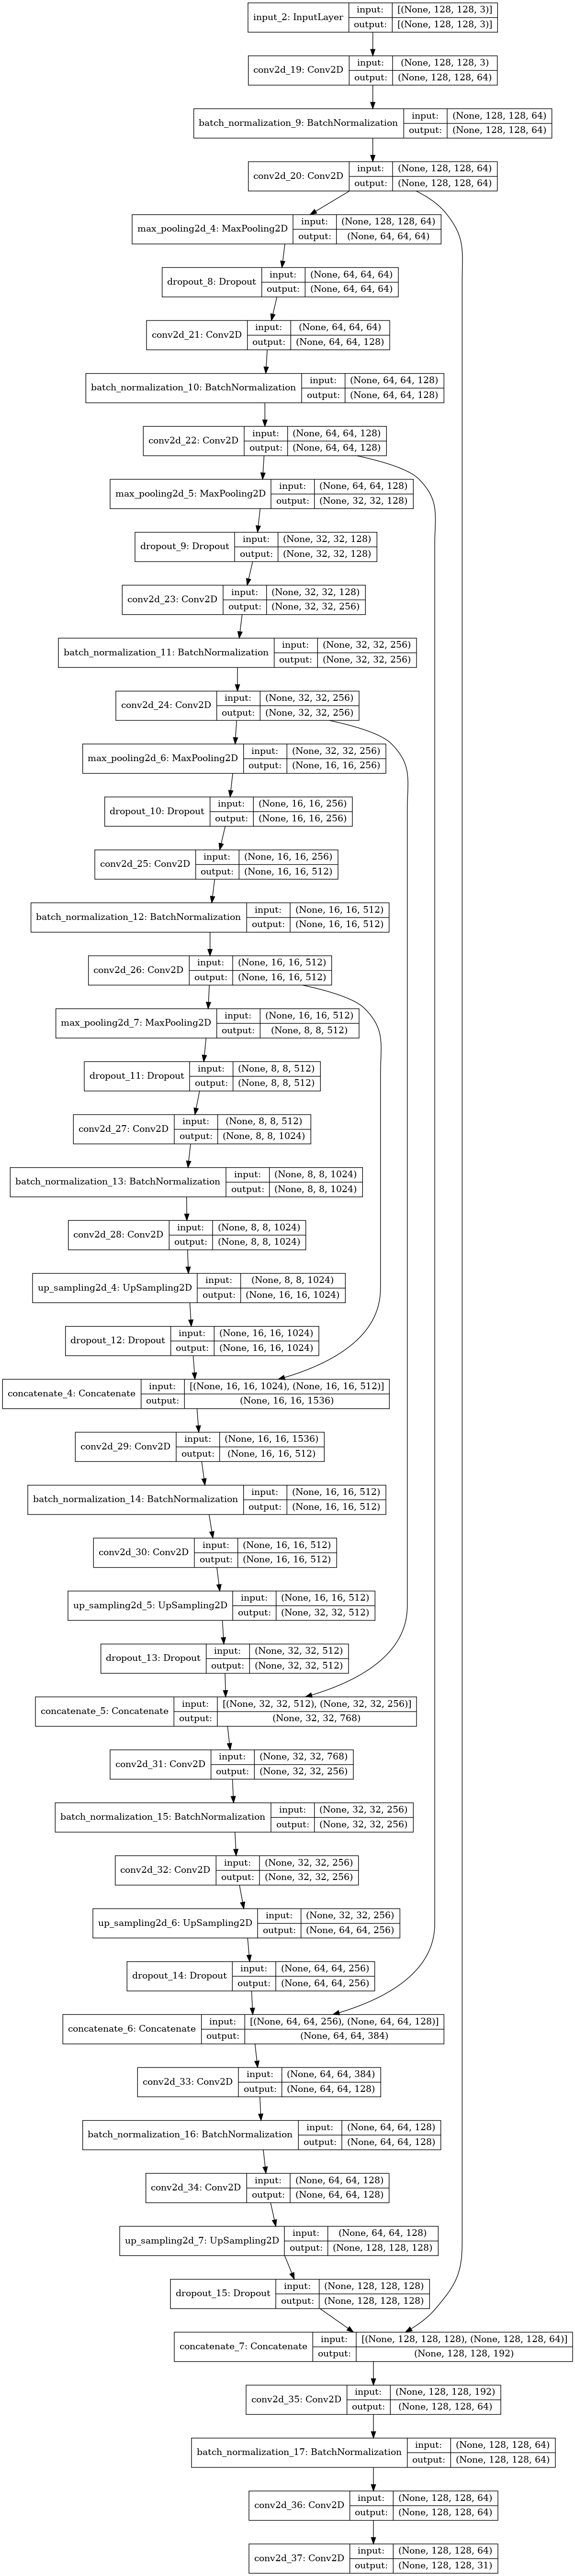

In [9]:
tf.keras.utils.plot_model(model, show_shapes = True)

# Utility Metrics and Callbacks classes

In [10]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
    super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, file_path, **kwargs):
        super().__init__(**kwargs)
        self.file_path = file_path
    
    def on_epoch_end(self, epoch, logs=None):
        img, mask = preprocess(self.file_path)
        img = np.array(img)
        img = np.reshape(img, (1, 128, 128, 3))
        pred = model.predict(img)
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (128, 128))
        fig, axes = plt.subplots(nrows = 1, ncols = 2)
        axes[0].imshow(mask)
        axes[0].set_title("Original Mask")
        axes[1].imshow(y_pred)
        axes[1].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

def plot_history(history):
  fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 7))
  # Training
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["loss"], ax = axes[0], label="Training Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["accuracy"], ax = axes[1], label="Training Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["mean_iou"], ax = axes[2], label="Training Mean IOU")

  # Validation
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_loss"], ax = axes[0], label="Validation Loss")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_accuracy"], ax = axes[1], label="Validation Accuracy")
  sns.lineplot(range(1, len(history.history["loss"]) + 1), history.history["val_mean_iou"], ax = axes[2], label="Validation Mean IOU")
  
  axes[0].set_title("Loss Comparison", fontdict = {'fontsize': 15})
  axes[0].set_xlabel("Epoch")
  axes[0].set_ylabel("Loss")

  axes[1].set_title("Accuracy Comparison", fontdict = {'fontsize': 15})
  axes[1].set_xlabel("Epoch")
  axes[1].set_ylabel("Accuracy")

  axes[2].set_title("Mean IOU Comparison", fontdict = {'fontsize': 15})
  axes[2].set_xlabel("Epoch")
  axes[2].set_ylabel("Mean IOU")
  plt.tight_layout()
  plt.show()

In [11]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ["accuracy", UpdatedMeanIoU(num_classes=num_classes, name = "mean_iou")])

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 50, restore_best_weights = True)
viz_callback = VizCallback("../input/cityscapes-image-pairs/cityscapes_data/val/106.jpg")

# Model Training

In [13]:
history = model.fit(x=X_train, y=Y_train, epochs = 100, batch_size = BATCH_SIZE, validation_data = (X_valid, Y_valid), callbacks=[early_stopping])

Epoch 1/100
93/93 [==============================] - 44s 335ms/step - loss: 1.1325 - accuracy: 0.6882 - mean_iou: 0.1250 - val_loss: 2.9092 - val_accuracy: 0.4911 - val_mean_iou: 0.0537
Epoch 2/100
93/93 [==============================] - 24s 253ms/step - loss: 0.8353 - accuracy: 0.7731 - mean_iou: 0.1855 - val_loss: 1.8458 - val_accuracy: 0.5076 - val_mean_iou: 0.0569
Epoch 3/100
93/93 [==============================] - 24s 253ms/step - loss: 0.7373 - accuracy: 0.8014 - mean_iou: 0.2191 - val_loss: 2.0783 - val_accuracy: 0.4474 - val_mean_iou: 0.0502
Epoch 4/100
93/93 [==============================] - 24s 253ms/step - loss: 0.6875 - accuracy: 0.8137 - mean_iou: 0.2358 - val_loss: 1.7090 - val_accuracy: 0.6400 - val_mean_iou: 0.0882
Epoch 5/100
93/93 [==============================] - 24s 253ms/step - loss: 0.6428 - accuracy: 0.8246 - mean_iou: 0.2523 - val_loss: 1.4814 - val_accuracy: 0.6615 - val_mean_iou: 0.1252
Epoch 6/100
93/93 [==============================] - 24s 253ms/step - 

# Training Results

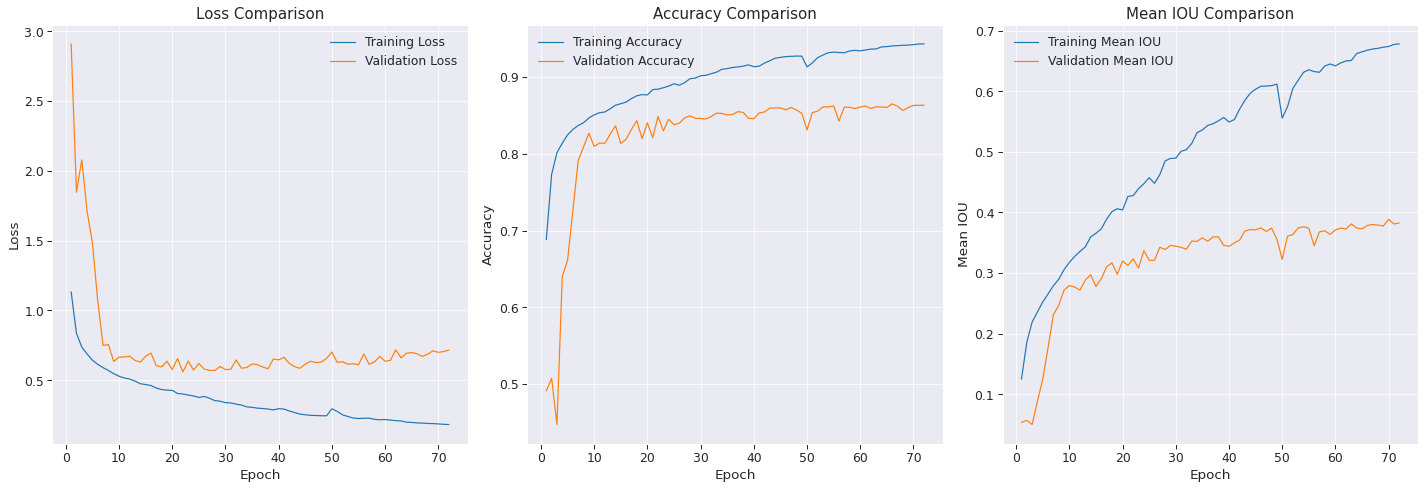

In [14]:
plot_history(history)

## Insights from training

1. It can be noticed that even after training for 35 epochs, the model has not achieved its peak performance. As the layer are initialised from scratch hence a more patience would have more. 

2. The training and validation performance for most of the metrics are almost similary except IOU score. 

3. It can be noticed from from Mean IOU plot that after 20-25 epochs the model starts to overfit when comparing side by side with accuracy and loss but the culprit for this is the range scale between different plots. 

# Model prediction on validation set

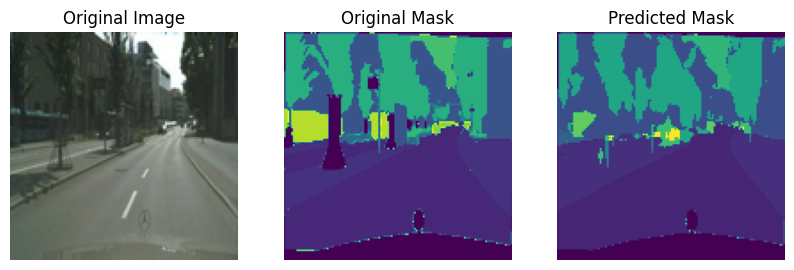

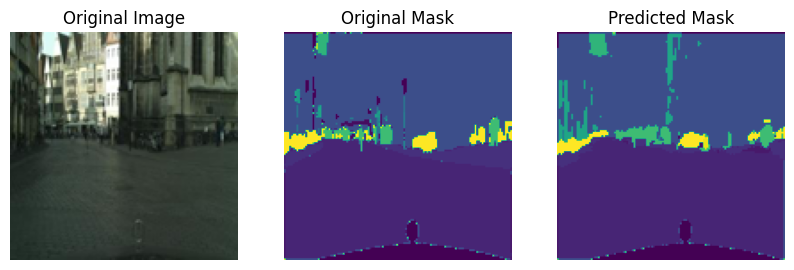

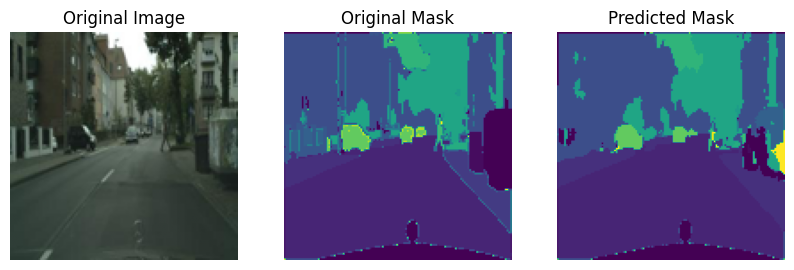

In [19]:
plt.style.use("default")
for i in os.listdir("../input/cityscapes-image-pairs/cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"../input/cityscapes-image-pairs/cityscapes_data/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = tf.math.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap="viridis")
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap="viridis")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

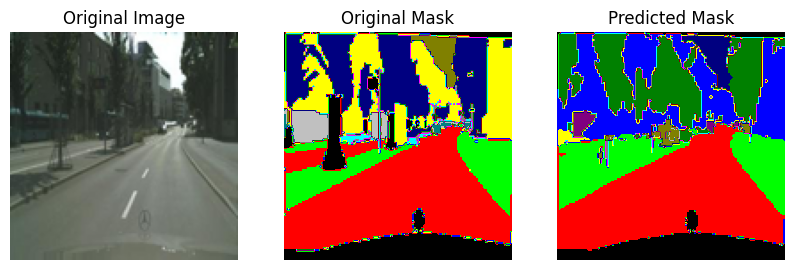

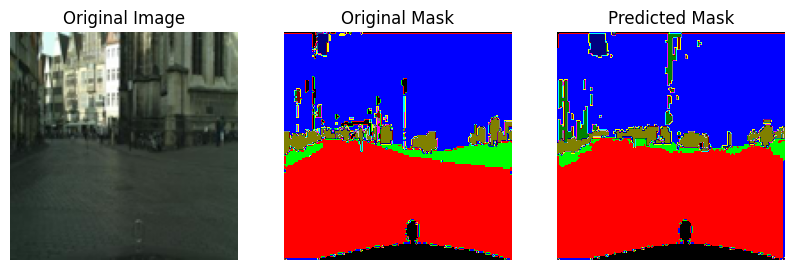

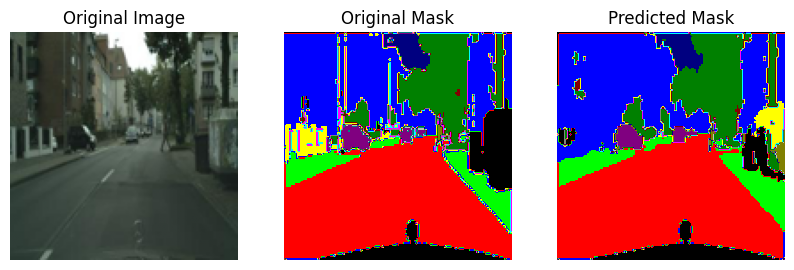

In [18]:
import matplotlib.colors as mcolors

# Define a custom colormap for the masks
cmap_mask = mcolors.ListedColormap(['#000000', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#00ffff', '#ff00ff', '#808080', '#800000', '#008000', '#000080', '#808000', '#800080', '#008080', '#c0c0c0', '#808000'])

plt.style.use("default")
for i in os.listdir("../input/cityscapes-image-pairs/cityscapes_data/val/")[:3]:
    img, mask = preprocess(f"../input/cityscapes-image-pairs/cityscapes_data/val/{i}")
    img = np.array(img)
    img = np.reshape(img, (1, 128, 128, 3))
    pred = model.predict(img)
    y_pred = tf.math.argmax(pred, axis=-1)
    y_pred = np.array(y_pred)
    y_pred = np.reshape(y_pred, (128, 128))
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    img = np.reshape(img, (128, 128, 3))
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(mask, cmap=cmap_mask)  # Use the custom colormap
    axes[1].set_title("Original Mask")
    axes[1].axis("off")
    axes[2].imshow(y_pred, cmap=cmap_mask)  # Use the custom colormap
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")
    plt.show()


Slight more training of the model in a supervised environment (making sure there is no overfitting), can help in achieving peak performance on the dataset.

## Incase you liked my work please do upvote the notebook and check out my other works as well. Really helps in keeping up the motivation. :)